# <center> Monte Carlo Option Pricing: MC vs. CVNN
    
### Authors: Rémi Leluc, François Portier, Johan Segers, Aigerim Zhuman
  
In the different python scripts are implemented the following :

- ### 2 models for the underlying assets: 
    * Black-Scholes (fixed volatility)
    * Heston (stochastic volatility with correlated Wiener processes)
    
- ### Various Classes for different Options: 
    * European option call
    * Asians option call
    * Barrier (In-Out and Up-Down) call,
    * Lookback European call
    
- ### Base Class Option which implements the 2 pricers: MC\_pricer and CVNN\_pricer

### Import Libraries

In [1]:
# standard python libraries for arrays and graphics
import numpy as np
import matplotlib.pyplot as plt 
# python library for finance 
import QuantLib as ql
# python class for Black-Scholes and Heston Models
from models import Black_Scholes_Model, Heston_Model
# python classes for closed-form formula of option prices
from analytical import euro_vanilla_call, barrier_call, euro_lookback_call
# python classes for various (exotic) options
from options import European_call_option, Asian_call_option
from options import Barrier_call_option, Lookback_European_call_option

# Part I. Generate some random paths

## I.A. Black-Scholes Model

### Generate some random paths with Black-Sholes Model (fixed volatility)

The asset price $S_t$ follows the Geometric Brownian Motion:

\begin{align*}
dS_t &=    \mu S_t dt + \sigma S_t dW_t 
\end{align*}
- fixed volatility $\sigma$

In [2]:
S0 = 100     # Inital stock price
T = 1        # Maturity time in year
r = 0.05     # Interest rate
𝜎 = 0.1      # volatility of the stock
m = 1000 # time steps for discretization (nodes)

# instance of BS model
my_model = Black_Scholes_Model(S0=S0,T=T,r=r,𝜎=𝜎,m=m)
# generate stock prices according to BSModel 
path_test = my_model.generate_paths(n=100,seed=0)

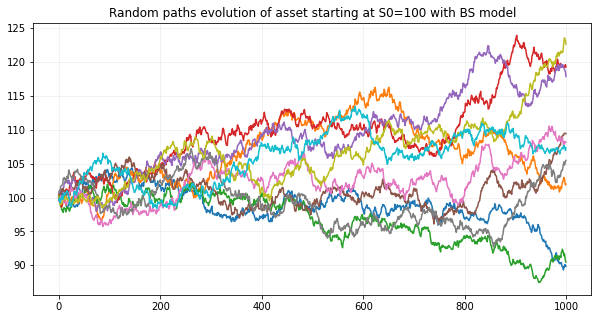

In [3]:
plt.figure(figsize=(10,5))
plt.title('Random paths evolution of asset starting at S0=100 with BS model')
for i in range(10):
    plt.plot(path_test[i])
plt.grid(alpha=0.2)
plt.show()

## I.B. Heston Model

###  Generate some random paths with Heston Model (stochastic volatility)
The asset price $S_t$ follows the following equation:

\begin{align*}
dS_t &=    \mu S_t dt + \sqrt{v_t} S_t dW_t^S \\
    dv_t &=\kappa(\theta-v_t) dt + \xi \sqrt{v_t}   dW_t^v
\end{align*}

- stochastic volatility $v_t$
- $\mu$: drift term
- $\theta$: long run average variance
- $\kappa$: rate of mean reversion
- $\xi$: vol of vol

Essentially what we are doing here is just simulating a standard geometric Brownian motion with non-constant volatility, where the change in S has relationship  ρ  with the change in volatility. Here we set the dirft term  μ  from above to equal the risk free rate  r:

\begin{align*}
S_{t+i} &= S_t \exp\left( (r-v_t/2)dt + \sqrt{v_i} dW_t^S\right) \\
v_{t+1} &= v_t + \kappa (\theta - v_t) dt + \xi \sqrt{v_t} dW_t^v
\end{align*}

In [4]:
S0 = 100     # Inital stock price
T = 1        # Maturity time in year
r = 0.05     # Interest rate
v0 = 0.1     # initial volatility of the stock
𝜃 = 0.02     # long run average variance
𝜅 = 4        # rate of mean reversion
𝜌 = 0.8      # instantaneous correlation
𝜉 = 0.9      # volatility of volatility (vol of vol)
m = 1000     # time steps for discretization (nodes)

# instance of Heston model
my_model = Heston_Model(S0=S0, T=T, r=r, v0=v0,
                        𝜃=𝜃, 𝜅=𝜅 ,𝜌=𝜌, 𝜉=𝜉, m=m)
# generate stock prices according to BSModel 
path_test = my_model.generate_paths(n=100,seed=2)

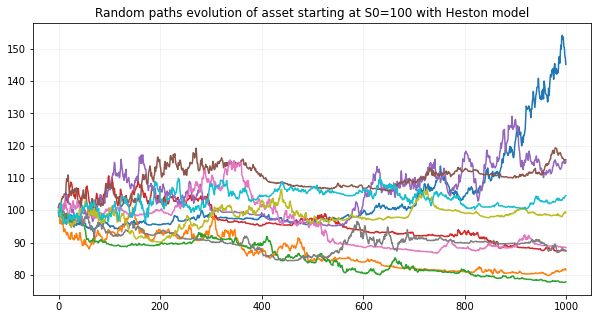

In [5]:
plt.figure(figsize=(10,5))
plt.title('Random paths evolution of asset starting at S0=100 with Heston model')
for i in range(10):
    plt.plot(path_test[i])
plt.grid(alpha=0.2)
plt.show()

# Part II. Option pricing part

## II.A. List of implemented options

### European Call option

- This option only depends on the final value $S_T$ of the stock price and the strike price $K$, the contract is

$$V(S_T) = \max\{ S_T - K; 0 \}.$$

### Asian Call option

- This option is path dependent and the contract depends on the arithmetic average $$V(S_T) = \max\{A(0,T) - K; 0 \}, \quad A(0,T) = \frac{1}{T}\int_{0}^T S_t dt$$

- In practice, discretization $A(S) = \sum_{i=1}^m S_{t_i}$ where $t_1,\ldots,t_m = 0,\Delta t, 2 \Delta t, ...,T$ is the discretization of the maturity time $T$ along $m=n_{mat}$ maturity points on the grid.

### LookBack European call option

- Fixed Lookback Option has a strike price set in advance. The payoff compares the minimum or maximum price of the underlying achieved to a fixed strike price on the expiry date. The payoff of a call lookback option is the difference between the highest value achived and the strike price. The payoff of a put lookback option is the difference between the strike value and the lowest value achived.
- This option is path dependent and the contract depends on the maximum price along the path 

$$V(S_T) = \max\{ S_{\max} - K; 0 \}, \quad S_{\max} = \max_{t \in [0,T]} S_t$$
- In practice, discretization along the paths with $m$ points $S_{\max} = \max_{i=1}^m S_{t_i}$

## II.B. Pricing with Black-Sholes model

## Fixed parameters

In [6]:
S0 = 100     # Inital stock price
T = 1        # Maturity time in year
m = 252      # Time periods until maturity (number of trading days in a year)
r = 0.05     # Interest rate
𝜎 = 0.15     # Volatility of the stock
K = 105      # Strike Price
up_H= 110
lo_H = 95

# instance of Black-Scholes Model
BS_model = Black_Scholes_Model(S0=S0, T=T, r=r, 𝜎=𝜎, m=m)

### European Call option

In [7]:
n_sample = 1000
# European call option
euro_stock_option = European_call_option(model=BS_model, K=K)
# True value
call_true = euro_vanilla_call(S0=S0,K=K,T=T,r=r,𝜎=𝜎)

In [8]:
# MC pricer
mc, err_mc = euro_stock_option.MC_pricer(n=n_sample,seed=0)

In [9]:
# CVNN pricer
mcnn, err_mcnn = euro_stock_option.CVNN_pricer(n=n_sample,N=int(1e5),seed=0)

In [10]:
print('European Call option')
print('True :', np.round(call_true,6))
print('MC   :', np.round(mc,6), ' error:', np.round(err_mc,6))
print('CVNN :', np.round(mcnn,6), ' error:', np.round(err_mcnn,6))

European Call option
True : 6.035564
MC   : 6.238552  error: 10.818465
CVNN : 6.034364  error: 0.127787


### Asian Call option

In [11]:
S0 = 100     # Inital stock price
T = 7/365    # Maturity time in year
m = 100      # Time periods until maturity (number of trading days in a year)
r = 0.05     # Interest rate
𝜎 = 0.3     # Volatility of the stock
K = 105      # Strike Price
up_H= 110
lo_H = 95

# instance of Black-Scholes Model
BS_model = Black_Scholes_Model(S0=S0, T=T, r=r, 𝜎=𝜎, m=m)

In [12]:
# Asian Call option
n_sample = 300
asian_stock_option = Asian_call_option(model=BS_model,K=K)

In [13]:
# True value by CVMonte Carlo approximation with large sample size
call_true, _ = asian_stock_option.CV_pricer(n=int(2e5),seed=0)

beta= 1.031760937449673


In [14]:
# MC estimate
mc, err_mc = asian_stock_option.MC_pricer(n=n_sample,seed=0)

In [15]:
# Geo Avg Control variate
# CVMC estimate
cvmc, err_cvmc = asian_stock_option.CV_pricer(n=n_sample,seed=0)

beta= 1.0324348242986152


In [16]:
# CVNN estimate
mcnn, err_mcnn = asian_stock_option.CVNN_pricer(n=300,N=int(1e6),seed=0)

In [17]:
print('Asian Call option')
print('True :', np.round(call_true,7))
print('MC   :', np.round(mc,7), ' error:', np.round(err_mc,7))
print('CVMC :', np.round(cvmc,7), ' error:', np.round(err_cvmc,7))
print('CVNN :', np.round(mcnn,7), ' error:', np.round(err_mcnn,7))

Asian Call option
True : 0.0217069
MC   : 0.0282887  error: 0.2069032
CVMC : 0.0215825  error: 0.003925
CVNN : 0.0210232  error: 0.0312064


### LookBack European Call option

In [18]:
S0 = 100     # Inital stock price
T = 7/365    # Maturity time in year
m = 100      # Time periods until maturity (number of trading days in a year)
r = 0.05     # Interest rate
𝜎 = 0.3     # Volatility of the stock
K = 105      # Strike Price
up_H= 110
lo_H = 95

# instance of Black-Scholes Model
BS_model = Black_Scholes_Model(S0=S0, T=T, r=r, 𝜎=𝜎, m=m)
# True value
call_lookback = euro_lookback_call(S0=S0,K=K,T=T,r=r,𝜎=𝜎)

n_sample = 500
# LookBack European Call option
lookback_stock_option = Lookback_European_call_option(model=BS_model,K=K)

In [19]:
# MC pricer
mc, err_mc = lookback_stock_option.MC_pricer(n=n_sample,seed=0)

In [20]:
# CVNN pricer
mcnn, err_mcnn = lookback_stock_option.CVNN_pricer(n=n_sample,N=int(1e6),seed=0)

In [21]:
print('LookBack European Call option')
print('True :', np.round(call_lookback,7))
print('MC   :', np.round(mc,7), ' error:', np.round(err_mc,7))
print('CVNN :', np.round(mcnn,7), ' error:', np.round(err_mcnn,7))

LookBack European Call option
True : 0.5265377
MC   : 0.5627796  error: 1.4153808
CVNN : 0.471399  error: 0.0361278


- seems than CVNN improves the performance

## II.C Pricing with Heston Model

In [22]:
S0 = 100     # Inital stock price
T = 1/6        # Maturity time in year
r = 0.1     # Interest rate
v0 = 0.1     # initial volatility of the stock
𝜃 = 0.02     # long run average variance
𝜅 = 4        # rate of mean reversion
𝜌 = 0.8      # instantaneous correlation
𝜉 = 0.9      # volatility of volatility (vol of vol)
m = 240     # time steps for discretization (nodes)
K=100
# instance of Heston model
H_model = Heston_Model(S0=S0, T=T, r=r, v0=v0,
                        𝜃=𝜃, 𝜅=𝜅 ,𝜌=𝜌, 𝜉=𝜉, m=m)

### Barrier option

In [23]:
up_H = 130
barrier_UI = Barrier_call_option(model=H_model,K=K,H=up_H,
                                        ud='up', io='in')

### European Call option

In [24]:
n_sample = 1000
# European call option
euro_stock_option = European_call_option(model=H_model, K=K)

In [25]:
# MC pricer
mc, err_mc = euro_stock_option.MC_pricer(n=n_sample,seed=0)

In [26]:
# CVNN pricer
mcnn, err_mcnn = euro_stock_option.CVNN_pricer(n=n_sample,N=int(1e5),seed=0)

### Compute True value with QuantLib library

In [27]:
# option data
maturity_date = ql.Date(31, 7, 2022)
spot_price = 100
strike_price = 105
volatility = 0.25 # the historical vols for a year
dividend_rate =  0
option_type = ql.Option.Call

risk_free_rate = 0.05
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()

calculation_date = ql.Date(1, 7, 2022)
ql.Settings.instance().evaluationDate = calculation_date

# construct the European Option
payoff = ql.PlainVanillaPayoff(option_type, strike_price)
exercise = ql.EuropeanExercise(maturity_date)
european_option = ql.VanillaOption(payoff, exercise)

spot_handle = ql.QuoteHandle(
    ql.SimpleQuote(spot_price)
)
flat_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, risk_free_rate, day_count)
)
dividend_yield = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, dividend_rate, day_count)
)
flat_vol_ts = ql.BlackVolTermStructureHandle(
    ql.BlackConstantVol(calculation_date, calendar, volatility, day_count)
)

initialValue = ql.QuoteHandle(ql.SimpleQuote(spot_price))
v0 = 0.1
kappa = 4
theta = 0.02
rho = 0.8
sigma = 0.9

hestonProcess = ql.HestonProcess(flat_ts, dividend_yield, initialValue, v0, kappa, theta, sigma, rho)
hestonModel = ql.HestonModel(hestonProcess)

engine_heston = ql.AnalyticHestonEngine(hestonModel)

european_option.setPricingEngine(engine_heston)
heston_price = european_option.NPV()
print("The theoretical price with Heston model is ", heston_price)

The theoretical price with Heston model is  1.8585158999876903


In [28]:
print('European Call option')
print('True :', np.round(heston_price,6))
print('MC   :', np.round(mc,6), ' error:', np.round(err_mc,6))
print('CVNN :', np.round(mcnn,6), ' error:', np.round(err_mcnn,6))

European Call option
True : 1.858516
MC   : 4.672969  error: 8.330003
CVNN : 4.983934  error: 0.08245


- Great improvement with CVNN compared to MC